In [8]:
import pickle
import matplotlib.pyplot as plt
import matplotlib.colors
import time

import h5py
import numpy as np
import os
import pickle
import tqdm
import glob
import mplhep
import astropy.coordinates as coord
import astropy.units as u

## Load the output of AHF


In [5]:
filepath = "/home/abdullahbazarov1/ML_gaia_old/"
# filepath = "/scratch-persistent/gaia/m12f/ahf/"
halos    = np.genfromtxt(filepath + "m12f-v2.z0.000.AHF_halos", unpack=True)
# hubble parameter @ z=0
h        = 0.702
# center ML-like halo (taken from m12f_res7100_center.txt)
center_x = 38711.76113 # kpc
center_y = 47665.07165 # kpc
center_z = 46817.26447 # kpc

id_halos = halos[0]
id_host  = halos[1]
Nsb      = halos[2] # number of substructures
Mvir     = halos[3]/h # total or virial mass of DM (sub)halos
Np       = halos[4] # number of particles contained within a (sub)halos
# (x_halos, y_halos, z_halos) are center of DM (sub)halos found by AHF
x_halos  = halos[5]/h-center_x
y_halos  = halos[6]/h-center_y
z_halos  = halos[7]/h-center_z
Vmax     = halos[16]

# principal axes rotation vectors (taken from m12f_res7100_center.txt)
rotation_vectors = np.asarray([[-0.464385978922, 0.291482979130, 0.836291417784], 
                               [0.708714933465, -0.443966939801, 0.548285053095], 
                               [0.531101502223, 0.847308107622, -0.000406318212]])

coordinate_vectors = np.transpose(np.asarray([x_halos, y_halos, z_halos]))

coordinate_vectors_rot = np.asarray( np.dot(coordinate_vectors, rotation_vectors.transpose()), 
                                    dtype=coordinate_vectors.dtype)

x_halos = coordinate_vectors_rot[:, 0]
y_halos = coordinate_vectors_rot[:, 1]
z_halos = coordinate_vectors_rot[:, 2] 
r_halos  = np.sqrt(np.power(x_halos, 2) + np.power(y_halos, 2) + np.power(z_halos, 2))

### Halo preselection

In [9]:
filename = filepath +"m12f-v2.z0.000.AHF_substructure"
def halo_id(filename):
    haloname = {}
    for iline, line in enumerate(open(filename).readlines()):
        if iline%2==0:
            ihalo, nsub = [int(x) for x in line.strip().split()]
            haloname[ihalo] = []
        else:
            subhalos = [int(x) for x in line.strip().split()]
            assert(len(subhalos) == nsub)
            haloname[ihalo] = subhalos
    return haloname
subhaloid = np.array(list(halo_id(filename)[0]))
other_subhaloid = []
all_subhaloid = []

for i in halo_id(filename).keys():
    all_subhaloid= np.hstack((halo_id(filename)[i], all_subhaloid))

other_subhaloid = np.setdiff1d( all_subhaloid, subhaloid)

location300_25 = []
cond1 = np.where(r_halos < 300) 
cond2 = np.where(Vmax > 5)
cond3 = np.where(r_halos > 25)
position2 = np.intersect1d(cond1,cond2)
position1 = np.intersect1d(position2,cond3)

for i in range (len(position1)):
    if (position1[i] in subhaloid):
        location300_25.append(position1[i])
    elif(position1[i] not in other_subhaloid):
            location300_25.append(position1[i])

            
np.hstack(location300_25)
pos = location300_25
r_halos = r_halos*u.kpc
x_halos = x_halos*u.kpc
y_halos = y_halos*u.kpc
z_halos = z_halos*u.kpc

### Star files

In [13]:
arrs = []
for fn in glob.glob("../ML_gaia/output/stars_shuf_*.npz")[:20]:
    arrs.append(np.load(fn)["gaia_data"])
selected_stars = np.concatenate(arrs)

c1 = coord.SkyCoord(ra=selected_stars[:, 0]*u.degree, dec=selected_stars[:, 2]*u.degree,
                    distance=(selected_stars[:, 4]*u.mas).to(u.pc, u.parallax()),
                    pm_ra_cosdec=selected_stars[:, 6]*u.mas/u.yr,
                    pm_dec=selected_stars[:, 8]*u.mas/u.yr,
                    radial_velocity=np.isnan(selected_stars[:, 15])*u.km/u.s,
                    frame='icrs')
v_center= [ 226.184921, 14.377288, -4.890565] * (u.km / u.s)  # [vx, vy, vz]
gc_frame = coord.Galactocentric( galcen_distance=8.2*u.kpc,galcen_v_sun=v_center, z_sun=0*u.pc)
gc1 = c1.transform_to(gc_frame)
x_stars = (gc1.x).to(u.kpc)
y_stars = (gc1.y).to(u.kpc)
z_stars = (gc1.z).to(u.kpc)
r_stars = (x_stars**2+y_stars**2+z_stars**2)**0.5

In [15]:
# Finding the distance between stars and halos
# Last two cells shuld run for all dataset
start = time.time()
#Run commented code for selected dataset

# dist =((x_stars[:, np.newaxis]-x_halos[pos])**2 
#        + (y_stars[:, np.newaxis]-y_halos[pos])**2 
#        + (z_stars[:, np.newaxis]-z_halos[pos])**2)**0.5    

# for example (comment or delete this code)
dist =((x_stars[:100000, np.newaxis]-x_halos[pos])**2 
       + (y_stars[:100000, np.newaxis]-y_halos[pos])**2 
       + (z_stars[:100000, np.newaxis]-z_halos[pos])**2)**0.5    


end = time.time() 
end-start

3.610323190689087

In [16]:
# dist = np.concatenate((dist1,dist2,dist3,dist4,dist5, ... distn),axis=1) #collecting outputs in one file

### Statistics

In [22]:
d_max = 10*u.kpc
np.unique(np.sum(dist<d_max, axis=1)>0, return_counts=True)

/usr/local/lib/python3.6/dist-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


(array([False,  True]), array([98617,  1383]))

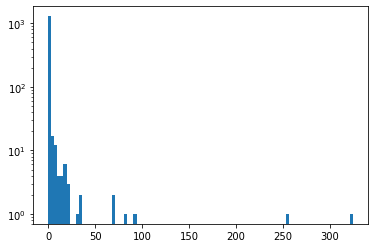

In [23]:
plt.hist(np.sum(dist<d_max, axis=0), bins = 100)
plt.yscale('log')


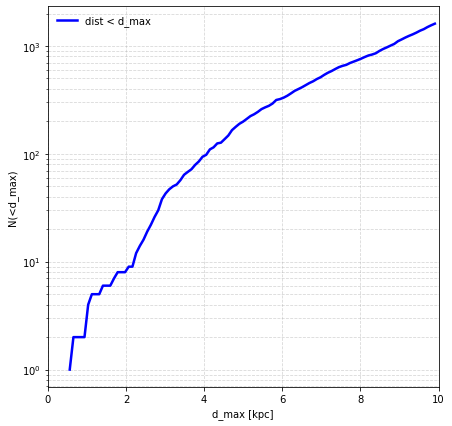

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
loc = np.where(dist < d_max)
values, base = np.histogram(dist[loc], bins=100)
cumulative = np.cumsum(values)
ax.plot(base[:-1], cumulative, c="blue", lw=2.5, label="dist < d_max")
ax.set_yscale("log")
# ax.set_xscale("log")
ax.set_xlabel("d_max [kpc]")
ax.set_ylabel("N(<d_max)") 
ax.legend(frameon=False)
ax.set_xlim([0, d_max/u.kpc])
ax.grid(which="both", ls="--", alpha=0.5)

/usr/local/lib/python3.6/dist-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


2.000040000800016e-05

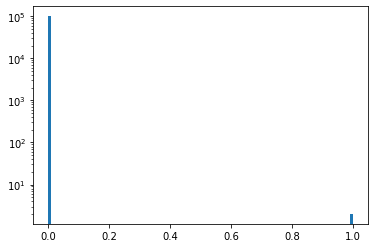

In [25]:
hist = plt.hist(np.sum(dist<1*u.kpc, axis=1), bins = 100)
plt.yscale('log')
counts, bins, _ = hist
np.sum(counts[1:]) / counts[0]


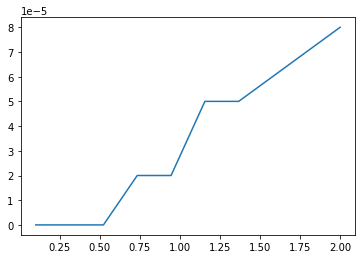

In [26]:
ratio = counts[1]/counts[0]
def compute_ratio(d_max):
    mask_dist = np.sum(dist<d_max, axis=1)>0
    n0 = np.sum(mask_dist==0)
    n1 = np.sum(mask_dist==1)
    ratio = n1/n0
    return ratio
xs = np.linspace(0.1*u.kpc, 2*u.kpc, 10)
ratios = [compute_ratio(x) for x in xs]
plt.plot(xs, ratios) 
